**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we randomly select a constant number of parameters for each service; we then repeat the 5-fold CV 10 times to make sure that the results are stable. 

In [1]:
import pandas as pd
import numpy as np
import xlsxwriter
from collections import OrderedDict, Counter
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
# Color codes for tables
light_green = '#e5ffe5'
dark_green = '#2e992e'

## Compute errors without tuning

In [2]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded', 'WeightedError']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [3]:
df = compute_all_errors_without_tuning().sort_index()
df = df.round(3)
df.to_csv('paper/submission/Table1.csv', sep=';')

In [4]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning().sort_index()
df = df.round(3)

df.style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
gender_api,0.079,0.05,-0.011,0.03,0.056
gender_api_full,0.198,0.07,-0.022,0.138,0.099
gender_guesser,0.222,0.026,0.002,0.201,0.073
genderize_io,0.143,0.05,0.022,0.097,0.07
names_api,0.231,0.041,0.007,0.198,0.086
names_api_full,0.179,0.034,0.004,0.15,0.067
namsor,0.128,0.043,0.007,0.089,0.061


In [5]:
pal = sns.light_palette("green")
pal.as_hex()

['#e5ffe5', '#b8e6b8', '#8acc8a', '#5cb35c', '#2e992e', '#008000']

In [6]:
# for the paper?
df = compute_all_errors_without_tuning().sort_index()
df = df.round(3)

# add colors using ExcelWriter; see http://xlsxwriter.readthedocs.io/working_with_conditional_formats.html
writer = pd.ExcelWriter('paper/submission/Table2.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.conditional_format('B2:B8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('C2:C8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('E2:E8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
worksheet.conditional_format('F2:F8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

# Close the Pandas Excel writer and output the Excel file.
writer.save()

## Plot distributions of the tuning parameters

Seaborn does not work with matplotlib subplots and its own grids are not applicable here. Matplotlib on the other hand has no good plots of bivariate distributions. Hence plotting each of the seven distributions separately...

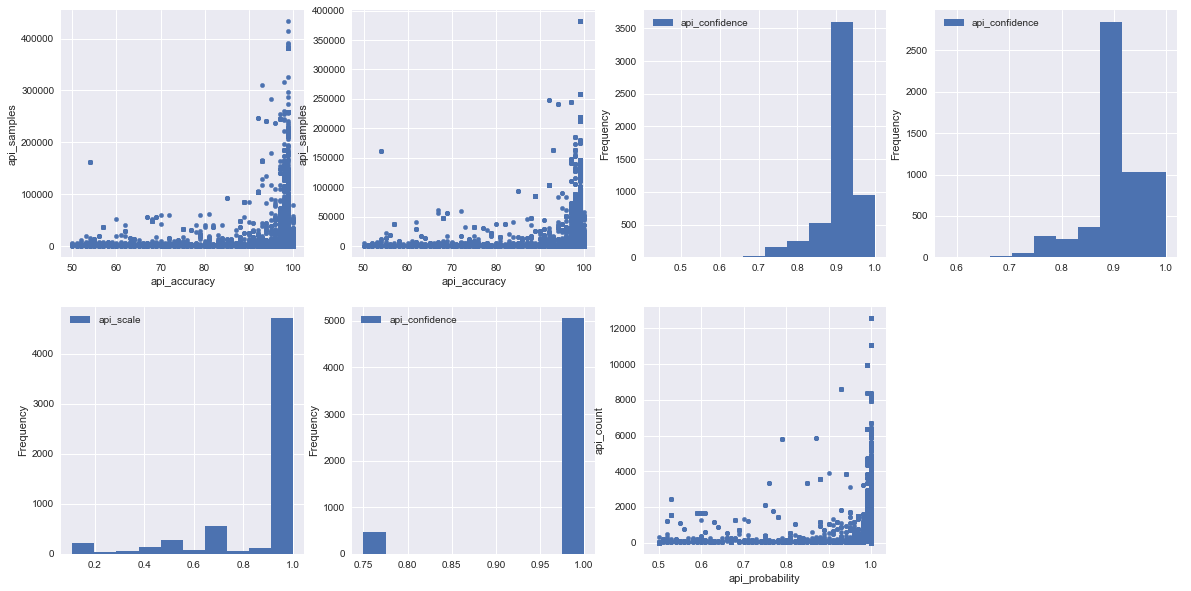

In [7]:
rows = 2
cols = 4
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10))
cmap = plt.get_cmap('PuRd')

i = 0
for row in range(rows):
    for col in range(cols):
        if i <= 6:
            s = REGISTERED_EVALUATORS[i]
            evaluator = s('all')
            evaluator.load_data(evaluated=True)
            evaluator.preprocess_tuning_params()
            evaluator._translate_api_response()
            evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

            if len(evaluator.tuning_params) == 1:
                evaluator.test_data[evaluator.tuning_params].plot(ax=axes[row,col], kind='hist')
            else:
                param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
                evaluator.test_data.plot.scatter(ax=axes[row,col], x=param_1,  y=param_2)

            i += 1
        else:
            axes[-1, -1].axis('off')


In [8]:
REGISTERED_EVALUATORS

[evaluators.GenderAPIEvaluator,
 evaluators.GenderAPIFullEvaluator,
 evaluators.NamesAPIEvaluator,
 evaluators.NamesAPIFullEvaluator,
 evaluators.NamSorEvaluator,
 evaluators.GenderGuesserEvaluator,
 evaluators.GenderizeIoEvaluator]

Text(0.5,1.02,'Parameter distribution of services with two tuning parameters')

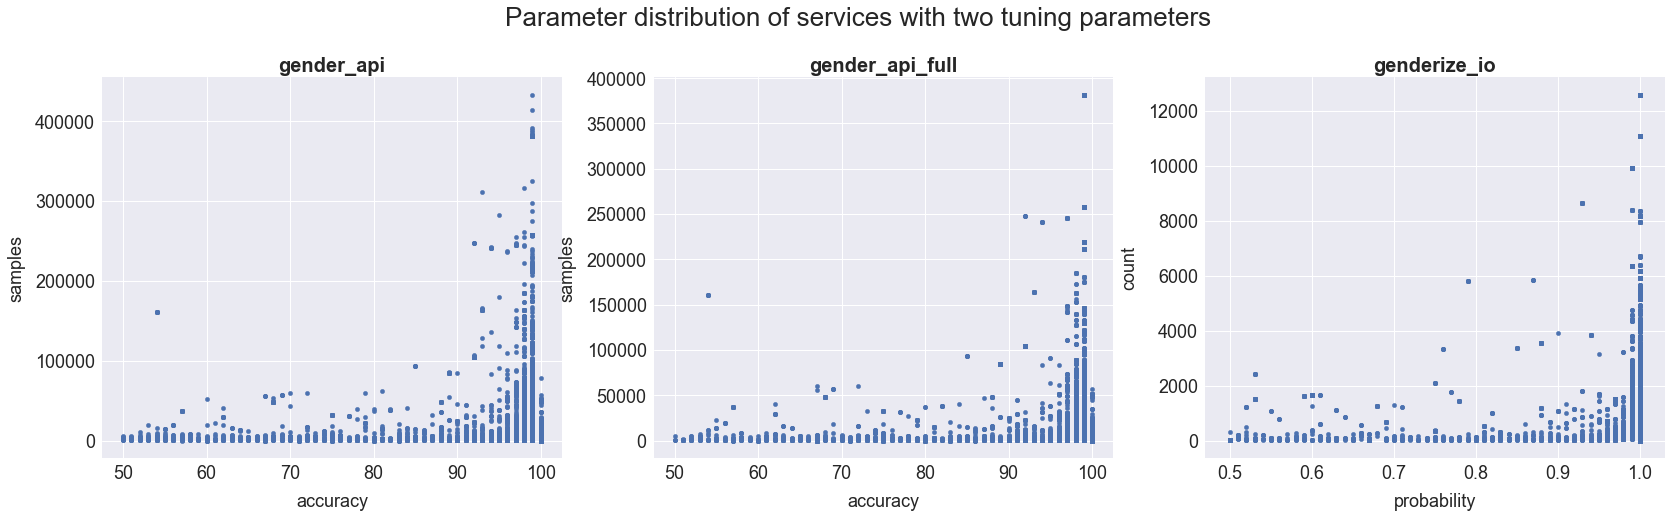

In [9]:
# plot for services with 2 parameters
rows = 1
cols = 3
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, 7))
cmap = plt.get_cmap('PuRd')


evals = [GenderAPIEvaluator, GenderAPIFullEvaluator, GenderizeIoEvaluator]
for i, e in enumerate(evals):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
    evaluator.test_data.plot.scatter(ax=axes[i], x=param_1,  y=param_2, fontsize=fs)
    
    axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)

plt.suptitle('Parameter distribution of services with two tuning parameters', fontsize=fs+8, y=1.02)


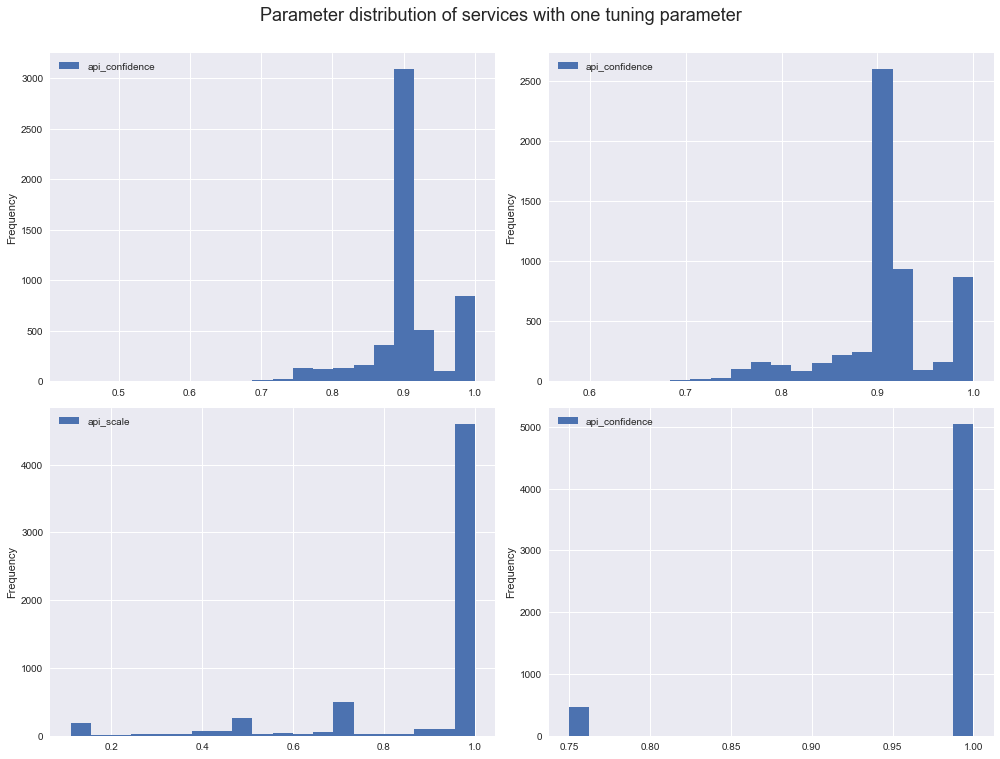

In [10]:
# plot for services with 1 parameter
rows = 2
cols = 2
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 10))

evals = [NamesAPIEvaluator, NamesAPIFullEvaluator, NamSorEvaluator, GenderGuesserEvaluator]

i = 0
for row in range(rows):
    for col in range(cols):
        e = evals[i]            
        evaluator = e('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

        evaluator.test_data[evaluator.tuning_params].plot(ax=axes[row,col], kind='hist', bins=20)
        #axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
        #axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
        #axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)
        i+=1

plt.suptitle('Parameter distribution of services with one tuning parameter', fontsize=fs, y=1.05)
fig.tight_layout()

savefig('paper/submission/param_distribution_one_param.png')       

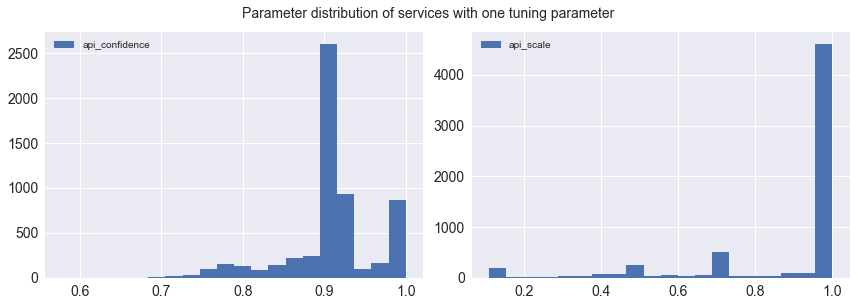

In [11]:
# histogram plot only for namsor and namesAPIfull
rows = 1
cols = 2
fs=14
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))

evals = [NamesAPIFullEvaluator, NamSorEvaluator]

for i in range(2):
    e = evals[i]            
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    evaluator.test_data[evaluator.tuning_params].plot(ax=axes[i], kind='hist', bins=20, fontsize=fs)
    axes[i].set_ylabel("", fontsize=fs, labelpad=10)
    #axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)
    i+=1

plt.suptitle('Parameter distribution of services with one tuning parameter', fontsize=fs, y=1.05)
fig.tight_layout()

savefig('paper/submission/param_distribution_one_param_2.png')       

## Random parameter sampling for all services

In [12]:
# sample usage
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_tuning_params()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

evaluator.sample_parameters(n_iter=3)

[{'api_accuracy': 98, 'api_samples': 780},
 {'api_accuracy': 99, 'api_samples': 68146},
 {'api_accuracy': 98, 'api_samples': 816},
 {'api_accuracy': 98, 'api_samples': 5},
 {'api_accuracy': 99, 'api_samples': 1386},
 {'api_accuracy': 99, 'api_samples': 23},
 {'api_accuracy': 97, 'api_samples': 38362},
 {'api_accuracy': 98, 'api_samples': 8797},
 {'api_accuracy': 99, 'api_samples': 1400},
 {'api_accuracy': 0, 'api_samples': 0}]

In [13]:
def sample_parameters_for_all_services(n_iter=20, method='square', random_state=None):
    service_to_param_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_param_range[evaluator.gender_evaluator] = evaluator.sample_parameters(n_iter=n_iter, 
                                                                                         method=method, 
                                                                                         random_state=random_state)
        
    return service_to_param_range

In [14]:
grid_20_20 = sample_parameters_for_all_services(n_iter=20, method="constant")
grid_30_30 = sample_parameters_for_all_services(n_iter=30, method="constant")
grid_50_50 = sample_parameters_for_all_services(n_iter=50, method="constant")
grid_100_100 = sample_parameters_for_all_services(n_iter=100, method="constant")
grid_200_200 = sample_parameters_for_all_services(n_iter=200, method="constant")

grid_20_400 = sample_parameters_for_all_services(n_iter=20, method="square")

In [15]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 200-200": grid_200_200, "f: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
gender_api 21
namsor 8
gender_guesser 3
names_api_full 14
gender_api_full 21
names_api 14
genderize_io 21
b: 30-30
gender_api 31
namsor 9
gender_guesser 3
names_api_full 22
gender_api_full 31
names_api 21
genderize_io 31
c: 50-50
gender_api 51
namsor 11
gender_guesser 3
names_api_full 29
gender_api_full 51
names_api 29
genderize_io 43
d: 100-100
gender_api 99
namsor 19
gender_guesser 3
names_api_full 49
gender_api_full 100
names_api 49
genderize_io 94
e: 200-200
gender_api 197
namsor 25
gender_guesser 3
names_api_full 80
gender_api_full 195
names_api 82
genderize_io 180
f: 20-400
gender_api 385
namsor 5
gender_guesser 2
names_api_full 15
gender_api_full 379
names_api 10
genderize_io 312


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [16]:
grid_20_20['gender_api']

[{'api_accuracy': 99, 'api_samples': 620},
 {'api_accuracy': 89, 'api_samples': 447},
 {'api_accuracy': 99, 'api_samples': 537},
 {'api_accuracy': 99, 'api_samples': 208},
 {'api_accuracy': 71, 'api_samples': 958},
 {'api_accuracy': 88, 'api_samples': 9874},
 {'api_accuracy': 98, 'api_samples': 1651},
 {'api_accuracy': 68, 'api_samples': 16},
 {'api_accuracy': 99, 'api_samples': 2134},
 {'api_accuracy': 81, 'api_samples': 31202},
 {'api_accuracy': 100, 'api_samples': 44635},
 {'api_accuracy': 98, 'api_samples': 7298},
 {'api_accuracy': 99, 'api_samples': 2492},
 {'api_accuracy': 100, 'api_samples': 31},
 {'api_accuracy': 94, 'api_samples': 126},
 {'api_accuracy': 97, 'api_samples': 95042},
 {'api_accuracy': 100, 'api_samples': 519},
 {'api_accuracy': 90, 'api_samples': 5644},
 {'api_accuracy': 99, 'api_samples': 13688},
 {'api_accuracy': 98, 'api_samples': 84333},
 {'api_accuracy': 0, 'api_samples': 0}]

In [17]:
grid_20_20['gender_guesser']

[{'api_confidence': 1.0}, {'api_confidence': 0.75}, {'api_confidence': 0}]

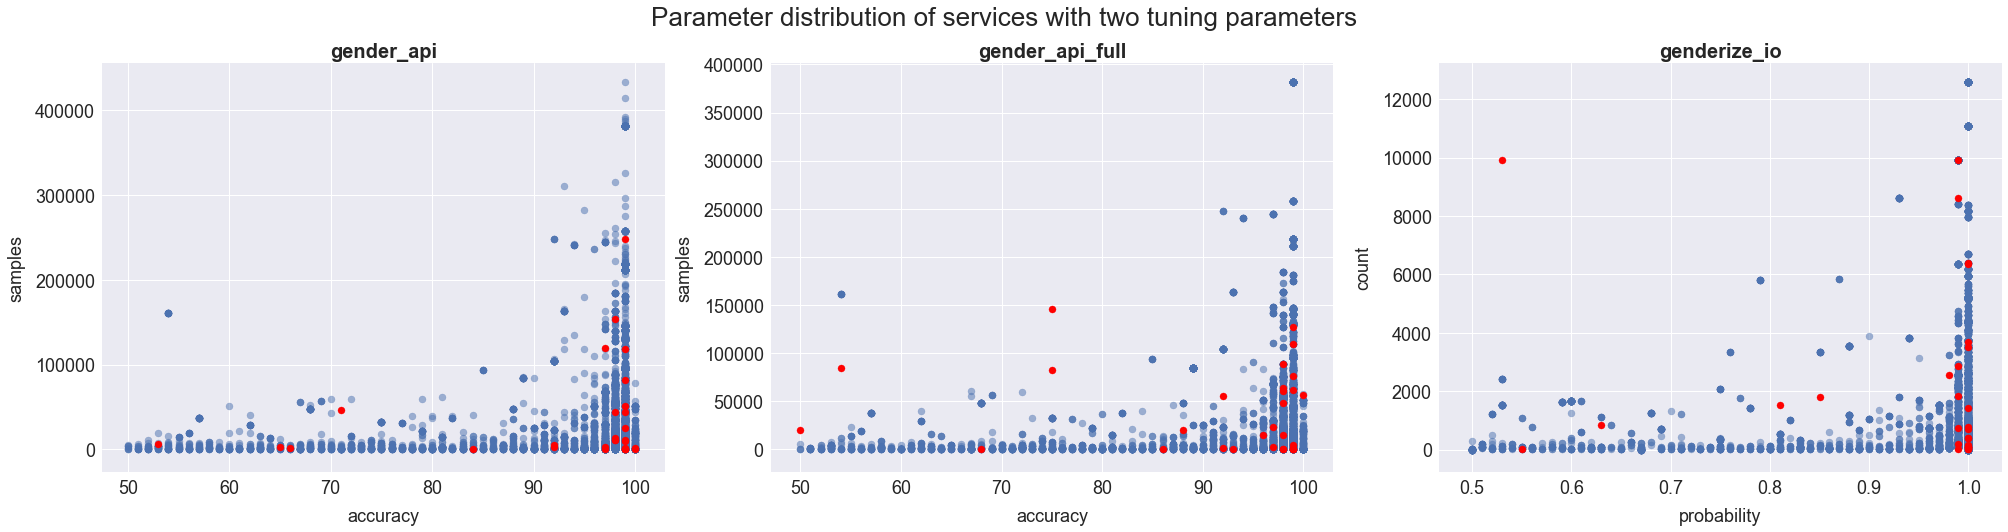

In [18]:
# plot for services with 2 parameters
rows = 1
cols = 3
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, 7))
cmap = plt.get_cmap('PuRd')


evals = [GenderAPIEvaluator, GenderAPIFullEvaluator, GenderizeIoEvaluator]
for i, e in enumerate(evals):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
    evaluator.test_data.plot.scatter(ax=axes[i], x=param_1,  y=param_2, fontsize=fs, alpha=0.5, s=50)
    
    samples = pd.DataFrame.from_dict(grid_30_30[evaluator.gender_evaluator])
    samples = samples[samples.sum(axis=1)!=0] # remove default tuple (0,0)
    samples.head()
    samples.plot.scatter(ax=axes[i], x=param_1, y=param_2, fontsize=fs, c='red', alpha=1, s=50)
    
    axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)

plt.suptitle('Parameter distribution of services with two tuning parameters', fontsize=fs+8, y=1.05)
fig.tight_layout()
savefig('paper/submission/param_distribution_two_params.png')

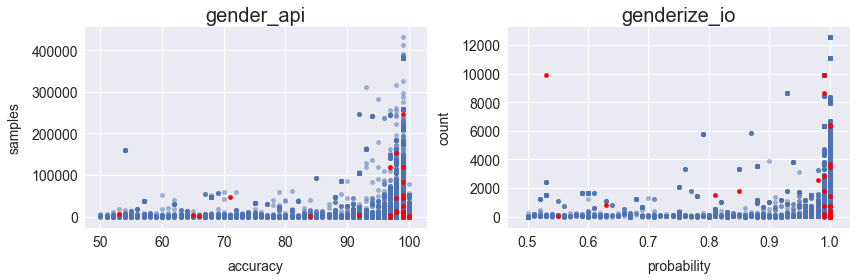

In [19]:
# plot for services with 2 parameters but without gender_api_full
rows = 1
cols = 2
fs=14
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 4))
cmap = plt.get_cmap('PuRd')


evals = [GenderAPIEvaluator, GenderizeIoEvaluator]
for i, e in enumerate(evals):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
    evaluator.test_data.plot.scatter(ax=axes[i], x=param_1,  y=param_2, fontsize=fs, alpha=0.5, s=20)
    
    samples = pd.DataFrame.from_dict(grid_30_30[evaluator.gender_evaluator])
    samples = samples[samples.sum(axis=1)!=0] # remove default tuple (0,0)
    samples.head()
    samples.plot.scatter(ax=axes[i], x=param_1, y=param_2, fontsize=fs, c='red', alpha=1, s=20)
    
    axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_title(evaluator.gender_evaluator, size=20)

#plt.suptitle('Parameter distribution of services with two tuning parameters', fontsize=fs+8, y=1.05)
fig.tight_layout()
savefig('paper/submission/param_distribution_two_params_2.png')

## Benchmark by repeated cross validation

The larger the number of parameter values the smaller the error on the train set. however, choosing too many parameter values makes it harder to compare services with very few parameters and those with many, and it increases the probability of overfitting.

Hence we choose rather small parameter lists but repeat the 5-fold cross validation 10 times and count, who came first (second) how often. This ensures higher stability in the results.

In [59]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, param_ranges, constraint_func=None, constraint_val=None, verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        param_range = param_ranges[evaluator_name]
        mean_test_error = evaluator.compute_k_fold_cv_score(n_splits=5, param_range=param_range, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val, 
                                                    verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, n_params, n_repeat=10, constraint_func=None, constraint_val=None, verbose=False):
    service_to_test_error_repeat = []
    for i in range(n_repeat):
        param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=i)
        service_to_test_error = tune(error_func, param_ranges, constraint_func=constraint_func, 
                                                  constraint_val=constraint_val, verbose=verbose)
        service_to_test_error_repeat.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return service_to_test_error_repeat

def explore_benchmark(benchmark):
    """Determine services that made it to the first and second place, and create dataframe with their CV errors 
    in each of the repetitions."""
    first_service, second_service = [], []
    for i, item in enumerate(benchmark):
        # print("first place in iteration round ", i, " :", item[0])
        # print("second place in iteration round ", i, " :", item[1])
        first_service.append(item[0][0])
        second_service.append(item[1][0])

    errors_per_service_and_iteration = pd.DataFrame.from_dict([{i[0]:i[1] for i in item} for item in benchmark])
    errors_per_service_and_iteration.index = ['Iteration ' + str(i) for i in errors_per_service_and_iteration.index]
    errors_per_service_and_iteration.loc['average error'] = errors_per_service_and_iteration.mean()
    errors_per_service_and_iteration = errors_per_service_and_iteration.round(3)

    print("Services at place 1:", Counter(first_service))
    print("Services at place 2:", Counter(second_service))
    display(errors_per_service_and_iteration)
    return errors_per_service_and_iteration

### Benchmark 1: minimize `error_with_unknown` with the constraint  `error_without_unknown < 0.05`
This benchmark means that the error of classifying women as men or 'unknown' and classifying men as women or 'unknown' is to be minimized, under the constraint that at most 5% of those classified as men or women have been missclassified.

In [21]:
benchmark_1 = tune_repeat(error_func=Evaluator.compute_error_with_unknown, n_params=30, n_repeat=10, 
                          constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05, verbose=True)

gender_api
minimal train error: 0.0809173517958 corresponding test error: 0.0708729472774
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0899848583171 corresponding test error: 0.110726643599
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
minimal train error: 0.0852260436946 corresponding test error: 0.0813148788927
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0793685121107 corresponding test error: 0.0770562770563
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0791522491349 corresponding test error: 0.0779220779221
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
Average test error: 0.0835785649494
gender_api_full
minimal train error: 0.255084379057 corresponding test error: 0.249783923941
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.253947653039 co

**Note: for some services, in particular 'NamesAPI', the constraint is not always satisfied and the following line is in the print: 'No parameter values satisfied given constraint'. In this case, test_error=1 is returned. **

In [22]:
benchmark_1[0]

[('gender_api', 0.083578564949429238),
 ('namsor', 0.13532051738420076),
 ('genderize_io', 0.14397253667110982),
 ('names_api_full', 0.17944207510281923),
 ('gender_guesser', 0.22235555419529601),
 ('names_api', 0.23170185956236264),
 ('gender_api_full', 0.2427689898841876)]

In [60]:
errors_per_service_and_iteration_1 = explore_benchmark(benchmark_1)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 9, 'genderize_io': 1})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
Iteration 0,0.084,0.243,0.222,0.144,0.232,0.179,0.135
Iteration 1,0.084,0.244,0.222,0.148,0.241,0.179,0.139
Iteration 2,0.084,0.228,0.222,0.146,0.232,0.179,0.135
Iteration 3,0.082,0.247,0.222,0.144,0.234,0.179,0.143
Iteration 4,0.083,0.238,0.222,0.144,0.241,0.179,0.139
Iteration 5,0.090,0.260,0.222,0.143,0.239,0.179,0.143
Iteration 6,0.082,0.232,0.222,0.145,0.232,0.179,0.143
Iteration 7,0.083,0.239,0.222,0.146,0.235,0.179,0.142
Iteration 8,0.088,0.232,0.222,0.144,0.235,0.179,0.141
Iteration 9,0.088,0.234,0.222,0.143,0.237,0.179,0.143


In [32]:
df = errors_per_service_and_iteration_1

writer = pd.ExcelWriter('paper/submission/Table3.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.conditional_format('B12:H12', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

writer.save()

### Benchmark 2: minimize `error_without_unknown` with the constraint  `error_unknown < 0.2`
This benchmark can be interpreted as follows: minimize the error of classifying women as men and vice versa, but under the constraint that at most 20% are left as 'unknown'. 

In [33]:
benchmark_2 = tune_repeat(error_func=Evaluator.compute_error_without_unknown, n_params=30, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_unknown, constraint_val=0.25, verbose=True)

gender_api
minimal train error: 0.00720421169299 corresponding test error: 0.0122630992196
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00803992237316 corresponding test error: 0.00889877641824
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00862788755914 corresponding test error: 0.0065717415115
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00860632981677 corresponding test error: 0.00663716814159
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00858012731802 corresponding test error: 0.006718924972
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
Average test error: 0.00821794205259
gender_api_full
minimal train error: 0.0344146685472 corresponding test error: 0.0292792792793
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 79}
minimal tra

In [34]:
errors_per_service_and_iteration_2 = explore_benchmark(benchmark_2)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 6, 'genderize_io': 4})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
Iteration 0,0.008,0.033,0.023,0.024,0.039,0.029,0.014
Iteration 1,0.010,0.030,0.023,0.013,0.041,0.030,0.014
Iteration 2,0.011,0.034,0.023,0.013,0.039,0.029,0.014
Iteration 3,0.008,0.030,0.023,0.014,0.040,0.029,0.014
Iteration 4,0.011,0.035,0.023,0.021,0.041,0.031,0.014
Iteration 5,0.008,0.042,0.023,0.016,0.040,0.029,0.014
Iteration 6,0.010,0.035,0.023,0.029,0.040,0.029,0.014
Iteration 7,0.010,0.040,0.023,0.013,0.039,0.029,0.014
Iteration 8,0.009,0.035,0.023,0.012,0.039,0.034,0.014
Iteration 9,0.006,0.037,0.023,0.022,0.039,0.029,0.014


In [53]:
df = errors_per_service_and_iteration_2

writer = pd.ExcelWriter('paper/submission/Table4.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.conditional_format('B12:H12', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

writer.save()

### Benchmark 3: minimize `weighted_error`
The 'weighted error' puts 5 times more wight on classifying women as men and vice versa than classifying both of them as 'unknown'

In [36]:
benchmark_3 = tune_repeat(error_func=Evaluator.compute_weighted_error, n_params=30, n_repeat=10, verbose=True)

gender_api
minimal train error: 0.0447655139744 corresponding test error: 0.0435193945128
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0435583691595 corresponding test error: 0.0483932670237
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0445603223513 corresponding test error: 0.0443396226415
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.044885177453 corresponding test error: 0.0430532054898
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0448135529055 corresponding test error: 0.043321299639
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
Average test error: 0.0445253578613
gender_api_full
minimal train error: 0.0892498148344 corresponding test error: 0.0845813119595
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train er

In [37]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
Iteration 0,0.045,0.088,0.073,0.063,0.086,0.067,0.057
Iteration 1,0.045,0.089,0.073,0.064,0.086,0.067,0.055
Iteration 2,0.045,0.091,0.073,0.061,0.086,0.067,0.057
Iteration 3,0.045,0.089,0.073,0.062,0.086,0.067,0.056
Iteration 4,0.046,0.088,0.073,0.064,0.086,0.067,0.056
Iteration 5,0.045,0.088,0.073,0.062,0.086,0.067,0.056
Iteration 6,0.046,0.091,0.073,0.063,0.086,0.067,0.056
Iteration 7,0.046,0.093,0.073,0.065,0.086,0.067,0.056
Iteration 8,0.056,0.089,0.073,0.062,0.086,0.067,0.057
Iteration 9,0.054,0.091,0.073,0.062,0.086,0.067,0.056


In [54]:
df = errors_per_service_and_iteration_3

writer = pd.ExcelWriter('paper/submission/Table5.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.conditional_format('B12:H12', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

writer.save()

## Exploration of error rate in dependence of probability-like parameter

For each service we consider the probability-like parameter, i.e. we ignore the count-like parameters for `genderAPI` and `Genderize.io`. (These parameters are not explicitely returned from the other services but they are hidden in the internal logics.) For a fixed range of parameter values we consider how the different errors vary depending on the parameter values.  

In [39]:
prob_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
exclude_params = {'api_count', 'api_samples'}

def compute_error_per_service_and_probability_range(error_func, prob_range=prob_range):
    service_to_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        service_to_error[evaluator_name] = {}

        evaluator = prepare_for_tuning(evaluator)
        # exclude count-like tuning parameter
        prob_param = set(evaluator.tuning_params).difference(exclude_params).pop() 

        # scale values for gender-API to [0,1]
        if evaluator_name == "gender_api" or evaluator_name == "gender_api_full":
            evaluator.test_data[prob_param] = evaluator.test_data[prob_param] * 0.01

        for threshold in prob_range:
            evaluator._translate_api_response(**{prob_param:threshold})
            conf_matrix = evaluator.compute_confusion_matrix(evaluator.test_data)
            service_to_error[evaluator_name].update({threshold: error_func(conf_matrix)})
    
    return pd.DataFrame.from_dict(service_to_error)


In [40]:
service_to_error_with_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_with_unknown)
service_to_error_without_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_without_unknown)
service_to_error_gender_bias = compute_error_per_service_and_probability_range(Evaluator.compute_error_gender_bias)
service_to_error_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_unknown)
service_to_weighted_error = compute_error_per_service_and_probability_range(Evaluator.compute_weighted_error)

In [41]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_with_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.128223
0.1,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.128223
0.2,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.142931
0.3,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.146392
0.4,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.154179
0.5,0.0789064,0.197958,0.222357,0.142758,0.231009,0.179443,0.16906
0.6,0.0918844,0.211628,0.222357,0.154871,0.231009,0.179443,0.203841
0.7,0.111092,0.233085,0.222357,0.17529,0.232047,0.180308,0.21682
0.75,0.123205,0.24589,0.222357,0.180654,0.237584,0.187922,0.288285
0.8,0.141028,0.262848,0.26406,0.190344,0.264752,0.222011,0.292438


In [42]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_without_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0429331
0.1,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0429331
0.2,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0322392
0.3,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0300826
0.4,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0264887
0.5,0.0503122,0.0698374,0.0264298,0.0502301,0.0407943,0.0342159,0.0225931
0.6,0.0388278,0.0580939,0.0264298,0.0364964,0.0407943,0.0342159,0.0166702
0.7,0.0272676,0.0458558,0.0264298,0.0285365,0.0406399,0.0338568,0.0141581
0.75,0.0231348,0.0390298,0.0264298,0.0261209,0.0402962,0.0333677,0.0134325
0.8,0.0174188,0.0326975,0.0139114,0.0225611,0.0389052,0.0308256,0.0127958


In [43]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.0891158
0.1,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.0891158
0.2,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.11438
0.3,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.119917
0.4,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.131165
0.5,0.030109,0.13774,0.201246,0.0974217,0.198304,0.150372,0.149853
0.6,0.0551999,0.163004,0.201246,0.122859,0.198304,0.150372,0.190344
0.7,0.0861741,0.196228,0.201246,0.151064,0.199515,0.151583,0.205572
0.75,0.10244,0.215262,0.201246,0.158678,0.205572,0.159889,0.278595
0.8,0.1258,0.23793,0.253677,0.171656,0.234989,0.197266,0.283267


In [44]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_weighted_error
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0561722,0.0986348,0.0731345,0.0702999,0.0859552,0.0672332,0.0613005
0.1,0.0561722,0.0986348,0.0731345,0.0702999,0.0859552,0.0672332,0.0613005
0.2,0.0561722,0.0986348,0.0731345,0.0702999,0.0859552,0.0672332,0.0566074
0.3,0.0561722,0.0986348,0.0731345,0.0702999,0.0859552,0.0672332,0.0558129
0.4,0.0561722,0.0986348,0.0731345,0.0702999,0.0859552,0.0672332,0.0550207
0.5,0.0561722,0.0986348,0.0731345,0.0702999,0.0860104,0.0672332,0.0558767
0.6,0.0499294,0.0934055,0.0731345,0.0627519,0.0860104,0.0672332,0.0608287
0.7,0.0452738,0.0902746,0.0731345,0.0619218,0.086192,0.0671892,0.0626683
0.75,0.0449353,0.0890087,0.0731345,0.0615214,0.0875202,0.0688123,0.0841683
0.8,0.0449071,0.089549,0.0766793,0.0614595,0.0945318,0.0762277,0.0851121


In [45]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_gender_bias
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00721884
0.1,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00721884
0.2,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00332161
0.3,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00176956
0.4,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00139414
0.5,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712281,0.00366599,0.00264604
0.6,-0.0102564,-0.0208807,0.00216638,0.0144013,0.00712281,0.00366599,0.00470186
0.7,-0.00833176,-0.0213132,0.00216638,0.0122299,0.00734976,0.00367122,0.00413853
0.75,-0.00616927,-0.0191841,0.00216638,0.0113122,0.00762361,0.00370752,0.00383785
0.8,-0.00435471,-0.0177112,-0.003246,0.0108628,0.00588102,0.00280233,0.00362144


## Exploration of the parameter space for the benchmark winner  `genderAPI`

In [46]:
gender_api = GenderAPIEvaluator('all')
gender_api.load_data(evaluated=True)
gender_api.preprocess_tuning_params()
gender_api._translate_api_response()
gender_api.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

gender_api_range = gender_api.sample_parameters(n_iter=30, method='square', random_state=0)

In [47]:
len(gender_api_range)

816

In [48]:
error_with_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                              error_func=Evaluator.compute_error_with_unknown, 
                                                              index=evaluator.test_data.index)

error_without_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                                 error_func=Evaluator.compute_error_without_unknown, 
                                                                 index=evaluator.test_data.index)

In [49]:
df_error_with_unknown = pd.Series(error_with_unknown).reset_index()
df_error_without_unknown = pd.Series(error_without_unknown).reset_index()

df_error_with_unknown.columns=['samples', 'accuracy', 'error_with_unknown']
df_error_without_unknown.columns=['samples', 'accuracy', 'error_without_unknown']

In [50]:
df_error_with_unknown.head()

,samples,accuracy,error_with_unknown
0,0,0,0.050412
1,50,22561,0.050412
2,51,1741,0.050779
3,51,3076,0.050779
4,51,16800,0.050962


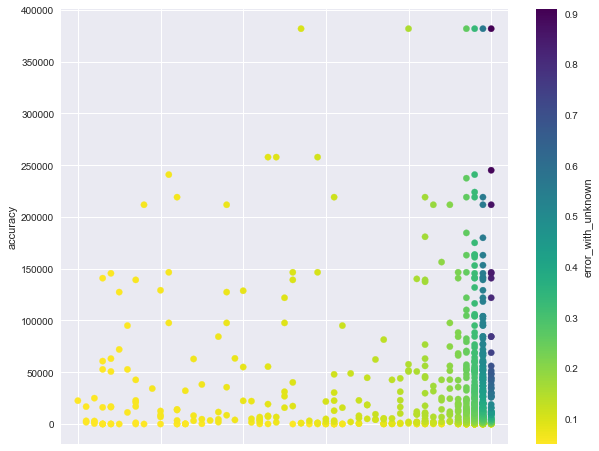

In [51]:
df_error_with_unknown.plot.scatter(x='samples', y='accuracy', c='error_with_unknown', xlim=(48,102), 
                                   cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

Here, we see the expected trend: the higher either of the parameter values, the higher the `error_with_unknown`.

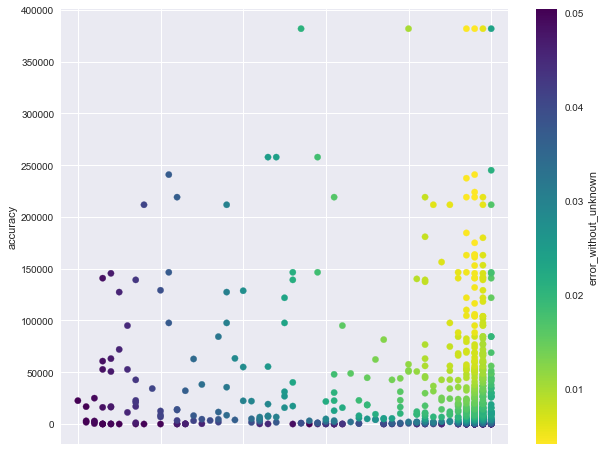

In [52]:
df_error_without_unknown.plot.scatter(x='samples', y='accuracy', c='error_without_unknown', xlim=(48,102), 
                                      cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

The tendency with the `error_without_unknown` is that the higher both parameter values the lower the error. 
**However, the far right column is not intuitive and needs further exploration.**

## TODO: have a closer look into the wrong classifications